<a href="https://colab.research.google.com/github/maksgorbachev/Project-Gorbachev/blob/main/Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install

In [ ]:
%pip install torch torchvision transformers scipy pycocotools coco-eval matplotlib deeplake

%pip install timm

import os.path as osp
from PIL import Image, ImageDraw

import numpy as np
import torch
import torchvision

from transformers import DetrImageProcessor, DetrForObjectDetection
from coco_eval import CocoEvaluator

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (40.0, 32.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

  Using cached timm-1.0.3-py3-none-any.whl (2.3 MB)


# Support functions

In [ ]:
# standard PyTorch mean-std input image normalization
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(800),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(_x):
    x_c, y_c, _w, _h = _x.unbind(1)
    b = [(x_c - 0.5 * _w), (y_c - 0.5 * _h),
         (x_c + 0.5 * _w), (y_c + 0.5 * _h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def detect(input_img, _model, img_transform):
    # mean-std normalize the input image (batch-size: 1)
    _img = img_transform(input_img).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert _img.shape[-2] <= 1600 and _img.shape[-1] <= 1600, \
        'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = _model(_img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], input_img.size)
    return probas[keep], bboxes_scaled

In [ ]:
def plot_results(pil_img, vis_boxes, prob=None):
    plt.figure(figsize=(10, 8))
    plt.imshow(pil_img)
    ax = plt.gca()
    for i, ((x_min, y_min, x_max, y_max), c) in enumerate(zip(vis_boxes.tolist(), COLORS * 100)):
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color=c, linewidth=3))
        if prob is not None:
            cl = prob[i].argmax()
            text = f'{CLASSES[cl]}: {prob[i][cl]:0.2f}'
            ax.text(x_min, y_min, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, detr_processor, train=True):
        ann_file = osp.join(img_folder, 'train_annotation.json' if train else 'test_annotation.json')
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = detr_processor

    def __getitem__(self, idx):
        input_img, detr_target = super(CocoDetection, self).__getitem__(idx)
        _image_id = self.ids[idx]
        detr_target = {'image_id': _image_id, 'annotations': detr_target}
        encoding = self.processor(images=input_img, annotations=detr_target, return_tensors="pt")
        pixel_values = encoding['pixel_values'].squeeze()
        detr_target = encoding['labels'][0]

        return pixel_values, detr_target

In [ ]:
processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')

train_dataset = CocoDetection('/content/drive/MyDrive/Diplom/dataset/train', processor, train=True)
val_dataset = CocoDetection('/content/drive/MyDrive/Diplom/dataset/train', processor, train=False)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Diplom/dataset/train/train_annotation.json'

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

NameError: name 'train_dataset' is not defined

Image n°675


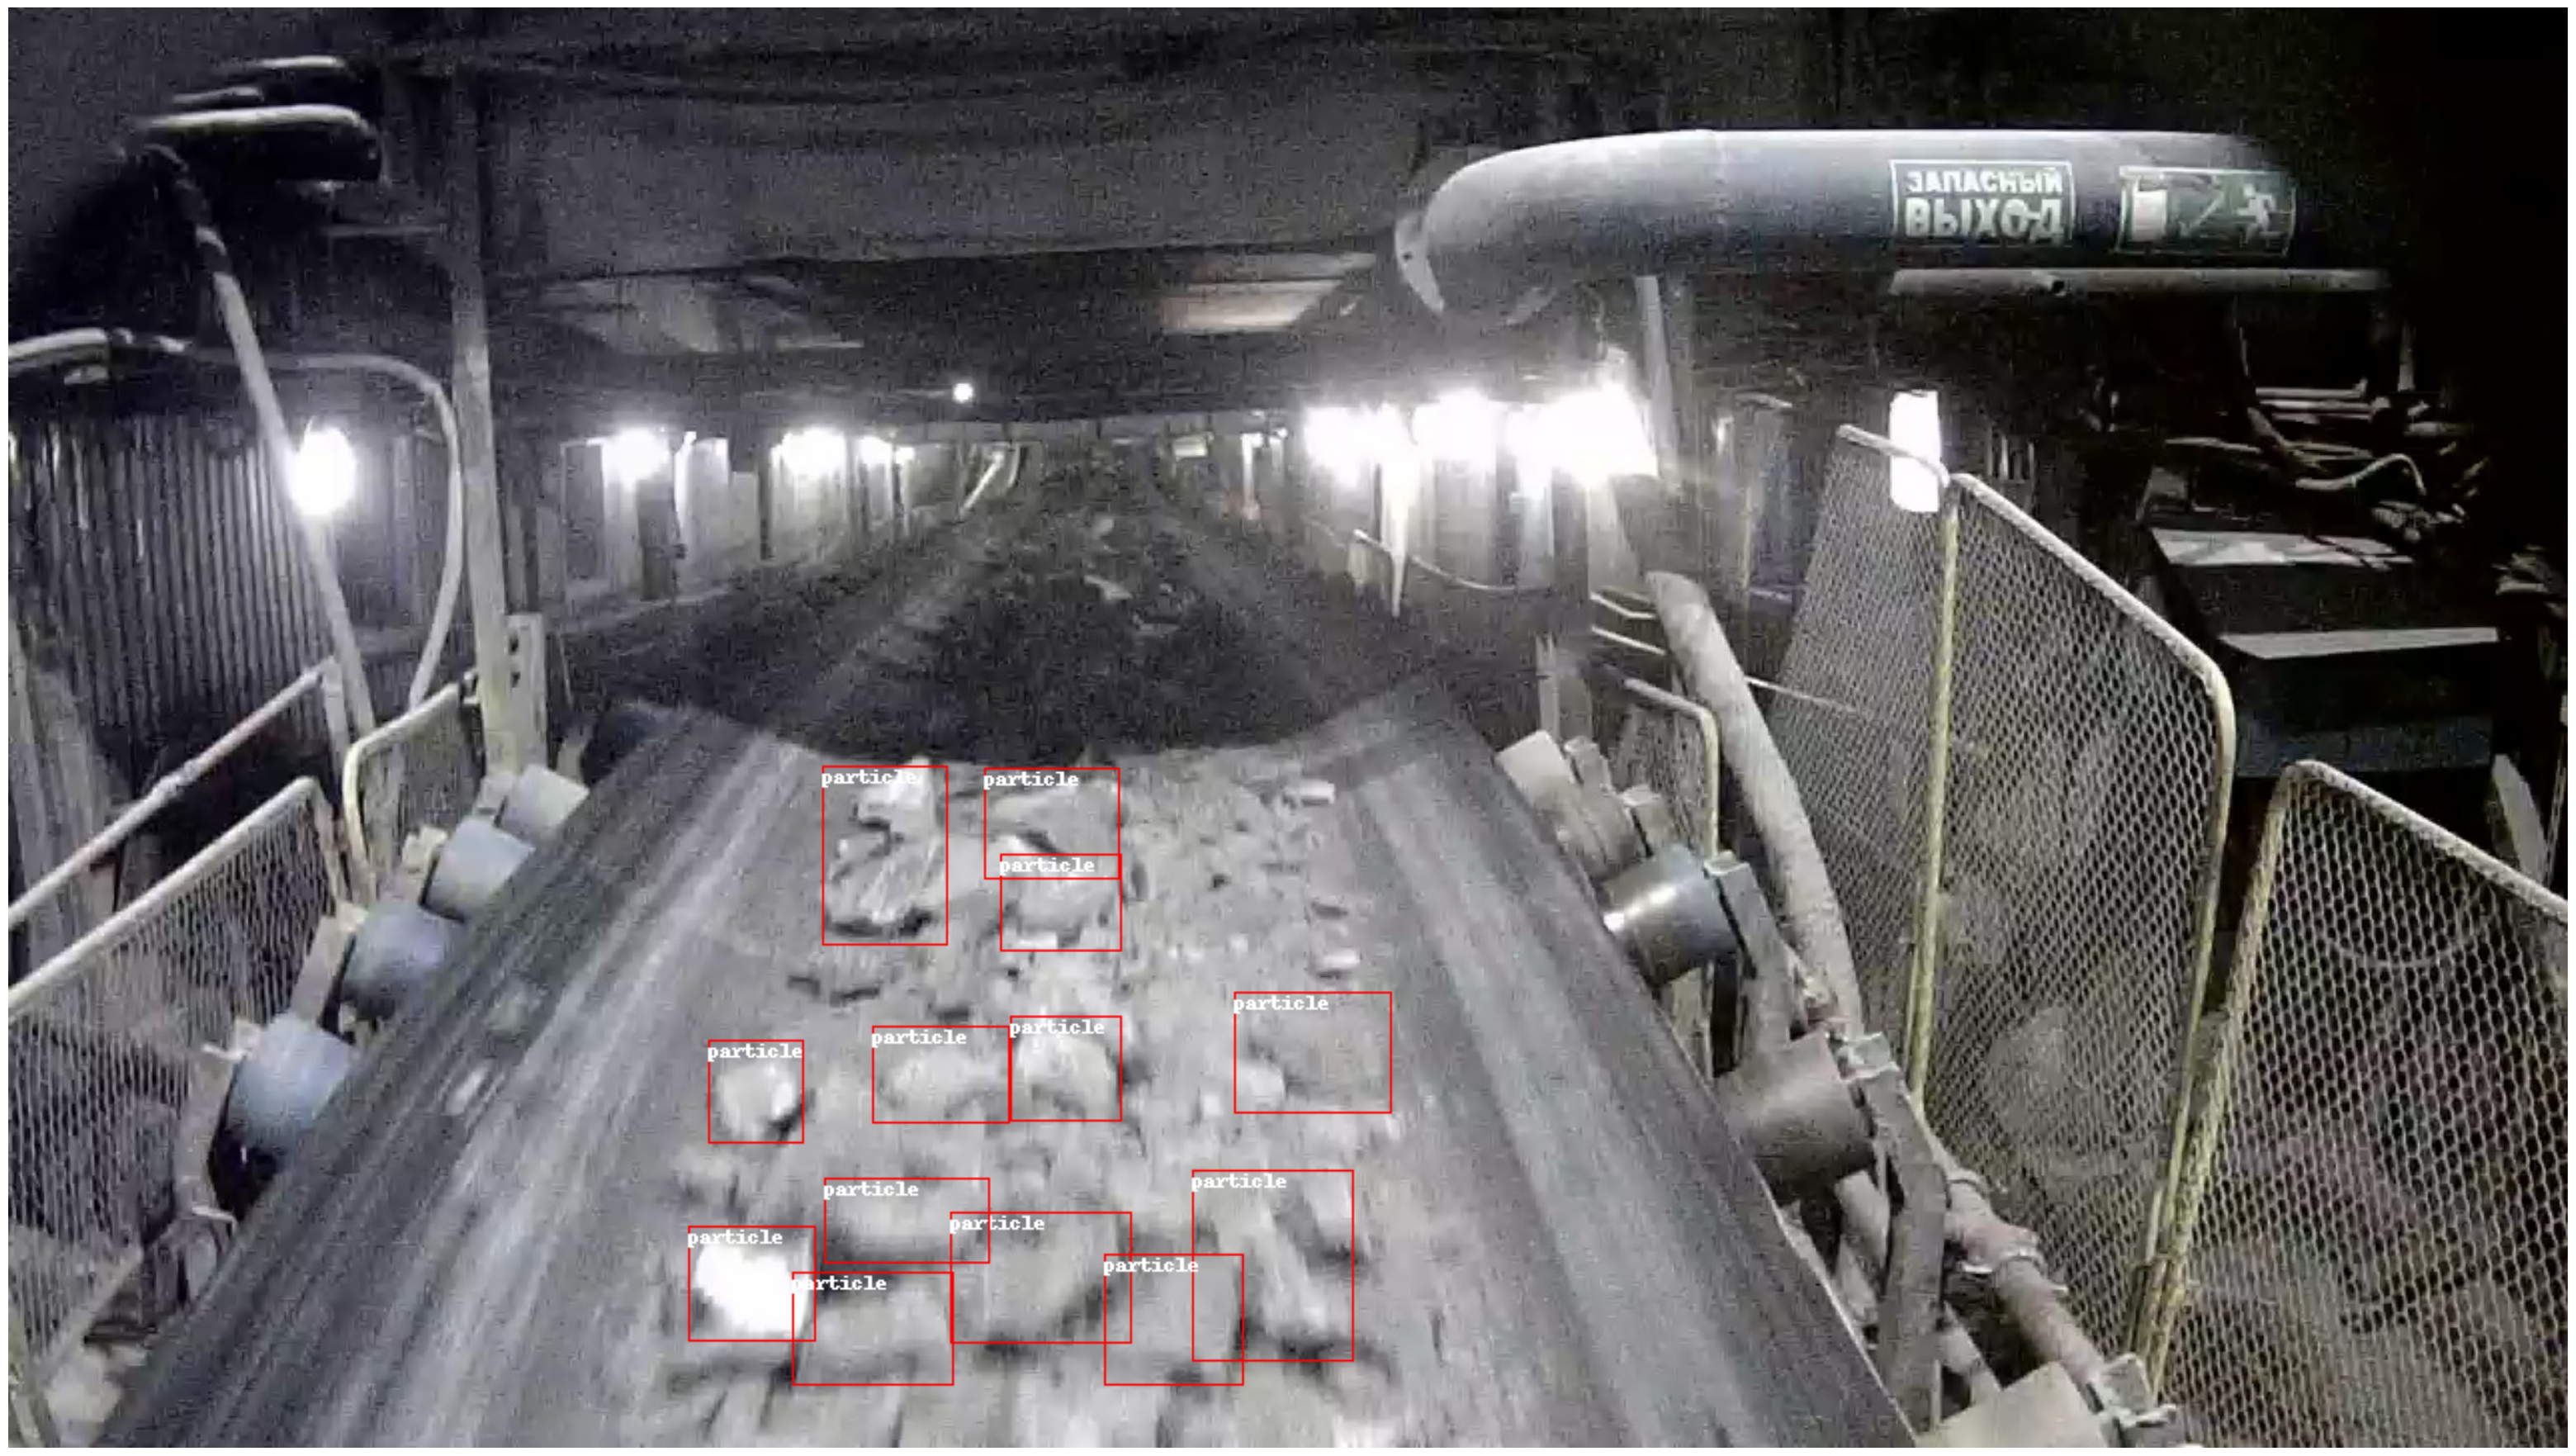

In [ ]:
image_ids = train_dataset.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(osp.join('/content/drive/MyDrive/Diplom/dataset/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k, v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 10

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = dict()
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)

# Training

In [ ]:
BATCH_SIZE = 10
DEVICE = 'cuda'
N_EPOCHS = 20
LR, LR_BACKBONE = 1e-4, 1e-5
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 0.1

In [ ]:
model = DetrForObjectDetection.from_pretrained(
    'facebook/detr-resnet-50',
    num_labels=1,
    ignore_mismatched_sizes=True
).to(DEVICE)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: ignored

In [ ]:
param_dicts = [
    {
        'params': [p for n, p in model.named_parameters() if 'backbone' not in n and p.requires_grad],
    },
    {
        'params': [p for n, p in model.named_parameters() if 'backbone' in n and p.requires_grad],
        'lr': LR_BACKBONE,
    },
]
optimizer = torch.optim.AdamW(param_dicts, lr=LR, weight_decay=WEIGHT_DECAY)

In [ ]:
def run_epoch(train=True):
    if train:
        dataloader = train_dataloader
        model.train()
    else:
        dataloader = val_dataloader
        model.eval()

    if train:
        optimizer.zero_grad()

    running_loss = 0.

    for batch in dataloader:
        pixel_values = batch['pixel_values'].to(DEVICE)
        pixel_mask = batch['pixel_mask'].to(DEVICE)
        labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch['labels']]
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        running_loss += outputs.loss.item()

        if train:
            outputs.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

    return running_loss / len(dataloader)

In [ ]:
for epoch in range(N_EPOCHS):
    epoch_train_loss = run_epoch(train=True)
    with torch.no_grad():
        epoch_val_loss = run_epoch(train=False)
    print(f'Epoch {epoch + 1}/{N_EPOCHS} - Train loss: {epoch_train_loss:.4f} - Val loss: {epoch_val_loss:.4f}')

# Evaluation

In [ ]:
def convert_to_xywh(_boxes):
    x_min, y_min, x_max, y_max = _boxes.unbind(1)
    return torch.stack((x_min, y_min, x_max - x_min, y_max - y_min), dim=1)

def prepare_for_coco_detection(_predictions):
    coco_results = []
    for original_id, prediction in _predictions.items():
        if len(prediction) == 0:
            continue

        _boxes = prediction["boxes"]
        _boxes = convert_to_xywh(_boxes).tolist()
        _scores = prediction["scores"].tolist()
        _labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": _labels[k],
                    "bbox": _box,
                    "score": _scores[k],
                }
                for k, _box in enumerate(_boxes)
            ]
        )
    return coco_results

In [ ]:
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(val_dataloader):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

# Visualization

In [ ]:
pixel_values, target = val_dataset[1]

pixel_values = pixel_values.unsqueeze(0).to(DEVICE)
model.to(DEVICE)

with torch.no_grad():
    outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (x_min, y_min, x_max, y_max),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color=c, linewidth=3))
        text = f'{score:0.2f}'
        ax.text(x_min, y_min, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# load image based on ID
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(osp.join('/content/drive/MyDrive/ColabNotebooks/solution_template/input/dataset/train', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(
    outputs, target_sizes=[(height, width)], threshold=0.001
)

results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])